I wrote up importance sampling for this problem in another notebook in this directory. However, there have been a great many problem with is so far, and I have not yet been able to diagnose if the problems are with my code or my statistics. Instead of continuing to muck up the main notebook, I will dedicate this notebook just to the debugging.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
colors = sns.color_palette()
import numpy as np
np.random.seed(0)#"Random"

/u/ki/swmclau2/PYENV/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/u/ki/swmclau2/PYENV/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#First, will need the parameters
redshift = .9 #one redshift, for now. 
nSamples = 500
vals = {}
z = [0.23, 1.5]
vals['Mp'] = [2.0e14, 1.0e14]
vals['A'] = [1.944, 0.293]
vals['B1'] = [1.97, 3.07]
vals['B2'] = [0.7, 1.2]
vals['B3'] = [0.40, 0.73]

#interpolates naively between the points given in the original paper
z_params = {}
from scipy.stats import linregress
for key, val in vals.iteritems():
    slope, intercept, r, p, stderr = linregress(z, val)
    z_params[key] = (slope, intercept)

#return the values of the parameters at a given z. 
getMassParams = lambda z : {key:val[0]*z+val[1] for key,val in z_params.iteritems()}

def n_approx(m,z):
    params = getMassParams(z)
    return params['A']*np.exp(-params['B1']*(m/params['Mp']) \
                    -0.5*params['B2']*(m/params['Mp'])**2 \
                    -0.166*params['B3']*(m/params['Mp'])**3)

def log_n_approx(m,z):
    params = getMassParams(z)
    return -1*(params['B1']*(m/params['Mp']) \
                    +0.5*params['B2']*(m/params['Mp'])**2 \
                    +0.166*params['B3']*(m/params['Mp'])**3)+np.log(params['A'])

In [3]:
#use MCMC to sample masses from the mass function
import emcee as mc
ndim = 1
nWalkers = 1000
nSteps = 500
nBurn = 400
nCores = 1

Mmin, Mmax = 1e13, 5e15
pos0 = np.random.uniform(np.log10(Mmin), np.log10(Mmax), size = nWalkers).reshape((nWalkers, ndim))

def log_p(logM, z):
    logM = logM[0]
    m = 10**logM
    if m>Mmax or m<Mmin:
        return -np.inf
    
    return log_n_approx(m, z)

sampler = mc.EnsembleSampler(nWalkers, ndim, log_p, args=[redshift],threads = nCores)

In [4]:
sampler.run_mcmc(pos0, nSteps);

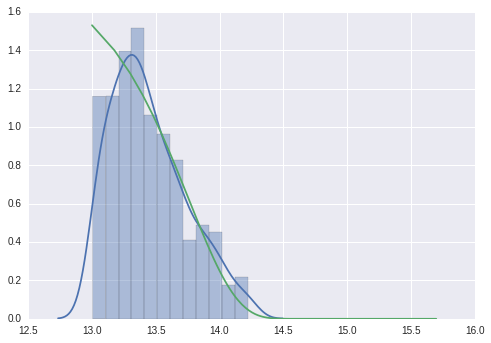

In [5]:
logMSamples = sampler.chain[:,nBurn:, :].reshape((-1, nSamples))[0,:]
mSamples = 10**logMSamples
sns.distplot(logMSamples)

x = np.linspace(Mmin,Mmax,1000)
#contstant mulitple is because seaborn normalizes the hist
plt.plot(np.log10(x),1.7*n_approx(x, redshift), color = colors[1])
plt.show()

In [6]:
M_piv = 2.35e14
logL0_true = 3.141
a_true, b_true = 0.842, -0.03
B_l_true = 0.642
sigma_l_true = 0.184

_A_lam = lambda a,b,z : a*pow((1+z)/1.3, b)

from scipy.stats import norm
#forward model
def logLam(logLam0, a, b, B_lam, z, M):
    A_lam = _A_lam(a,b,z)
    return logLam0+A_lam*np.log(M/M_piv)+B_lam*np.log((1+z)/1.3)

def logLamSample(logLam0, a, b, B_lam,sigma_lam, z,M):
    return norm.rvs(loc = logLam(logLam0, a, b, B_lam, z, M), scale = sigma_lam, size = M.shape[0])

In [7]:
logRichness = logLamSample(logL0_true, a_true, b_true, B_l_true, sigma_l_true, redshift, mSamples)

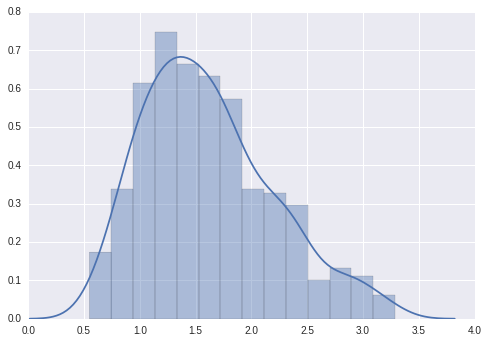

In [8]:
sns.distplot(logRichness)

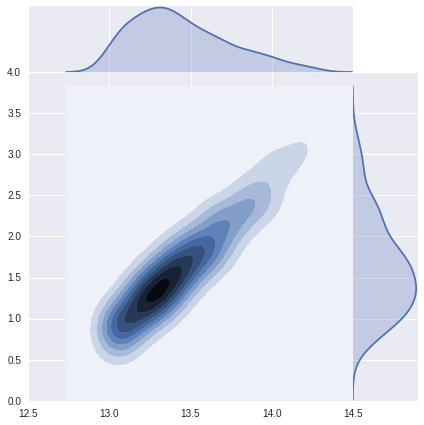

In [9]:
sns.jointplot(logMSamples, logRichness, kind = 'kde', stat_func = None, space = 0)

In [10]:
from scipy.stats import gamma, norm, expon, t
from itertools import izip
from scipy.misc import logsumexp

#returns a logmass given a richness
def invLogLam(logLam0, a, b, B_lam, z, logRich):
    A_lam = _A_lam(a,b,z)
    return np.log(M_piv)+(logRich-logLam0-B_lam*np.log((1+z)/1.3))/A_lam
#TODO Make this one synonymous with it non-inverse version
#TODO Consider checking if logRich is a vector or a number, and acting accodingly. 
nSamples = 100
def invLogLamSample(logLam0, a, b, B_lam,sigma_mass, z,logRich, size = nSamples):
    mu = invLogLam(logLam0, a, b, B_lam, z, logRich)
    if sigma_mass == 0:
        return mu
    return np.array([norm.rvs(loc = m, scale = sigma_mass, size =  (size,)) for m in mu])#( logRich.shape[0], size)

#draw one set of samples for all steps. Speedup!
#TODO Check the bases on everything, maybe the bug is from there
sigma_mass = 1 #TODO idk what this should be; i suppose it's my discretion, or some relation to

logMassSamples = invLogLamSample(logL0_true, a_true, b_true, B_l_true,sigma_mass, redshift, logRichness)
massSamples = np.exp(logMassSamples)

logPMass = log_n_approx(massSamples,redshift)
df = 1
logPSample = np.array([t.logpdf(lms,df, loc = invLogLam(logL0_true, a_true, b_true, B_l_true, redshift, lr), scale = sigma_mass)\
                     for lms, lr in izip(logMassSamples, logRichness)])

def log_liklihood(logL0, a,b, B_l, sigma, z, logRich):

    logPRich = np.array([norm.logpdf(lr, loc =logLam(logL0, a, b, B_l, z, ms), scale = sigma)\
                         for lr, ms in izip(logRich, massSamples)])
    
    logL_k = logsumexp(logPRich+logPMass-logPSample, axis = 1) - np.log(nSamples)#mean of weights

    return np.sum(logL_k)

In [11]:
def log_liklihood_known(logL0, a,b, B_l, sigma, z, logRich, M):
    return np.sum(norm.logpdf(logRich, loc =logLam(logL0, a, b, B_l, z, M), scale = sigma))

In [12]:
#pairs to do
#logL v a
#logL v b
#logL v B
#a v b
#a v B
#b v B
gridSize = 100
grid_logLva = np.zeros((gridSize,gridSize))
grid_logLva_known = np.zeros((gridSize,gridSize))
a_vals = np.linspace(a_true-1, a_true+1, num = gridSize)
logL0_vals = np.linspace(logL0_true-1, logL0_true+1, num = gridSize)
#b_vals = np.linspace(b_true-.1, b_true+.1, num = gridSize)
#B_l_vals = np.linspace(B_l_true-1, B_l_true+1, num = gridSize)
#sigma_l_vals = np.linspace(.01, sigma_l_true+.75, num = gridSize)
for i, logL0 in enumerate(logL0_vals):
    for j, a in enumerate(a_vals):
        grid_logLva[i,j] = log_liklihood(logL0, a,b_true, B_l_true, sigma_l_true, redshift, logRichness)
        grid_logLva_known[i,j] = log_liklihood_known(logL0, a,b_true, B_l_true, sigma_l_true, redshift, logRichness, mSamples)

In [13]:
cmap = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap = True)
im = plt.imshow(grid_logLva-grid_logLva.max(), cmap = cmap)
x = np.argmax(grid_logLva)
x, y = x/gridSize, x%gridSize
plt.scatter(y,x, color = 'r', label = 'Most Likely')
plt.scatter(50,50, color = 'm', label='Truth')
plt.colorbar(im)
plt.legend(loc = 'best')
plt.ylabel('$a$')
plt.xlabel('$\log{\lambda_0}$')
plt.title('Full Grid Log Space')
plt.show()

im = plt.imshow(grid_logLva_known-grid_logLva_known.max(), cmap = cmap)
x = np.argmax(grid_logLva_known)
x, y = x/gridSize, x%gridSize
plt.scatter(y,x, color = 'r', label = 'Most Likely')from scipy.stats import linregress

plt.scatter(50,50, color = 'm', label='Truth')
plt.colorbar(im)
plt.legend(loc = 'best')
plt.ylabel('$a$')
plt.xlabel('$\log{\lambda_0}$')
plt.title('Full Grid Log Space Known')
plt.show()

SyntaxError: invalid syntax (<ipython-input-13-4d6698178581>, line 17)

In [ ]:
cmap = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap = True)
im = plt.imshow(np.exp(grid_logLva-grid_logLva.max()), cmap = cmap)
x = np.argmax(grid_logLva)
x, y = x/gridSize, x%gridSize
plt.scatter(y,x, color = 'r', label = 'Most Likely')
plt.scatter(50,50, color = 'm', label='Truth')
plt.colorbar(im)
plt.legend(loc = 'best')
plt.ylabel('$a$')
plt.xlabel('$\log{\lambda_0}$')
plt.title('Full Grid Log Space')
plt.show()

im = plt.imshow(np.exp(grid_logLva_known-grid_logLva_known.max()), cmap = cmap)
x = np.argmax(grid_logLva_known)
x, y = x/gridSize, x%gridSize
plt.scatter(y,x, color = 'r', label = 'Most Likely')
plt.scatter(50,50, color = 'm', label='Truth')
plt.colorbar(im)
plt.legend(loc = 'best')
plt.ylabel('$a$')
plt.xlabel('$\log{\lambda_0}$')
plt.title('Full Grid Log Space Known')
plt.show()

In [ ]:
print logL0_true, a_true

In [ ]:
from scipy.stats import t
lr = logRichness[0]
logMArray = np.linspace(np.log10(Mmin), np.log10(Mmax), 1000)
mArray = 10**logMArray
logPMass = log_n_approx(mArray,redshift)
logPMass-=logPMass.max()
sigma_mass = .1
df = 1
#logPSample = norm.logpdf(logMArray, loc = invLogLam(logL0_true, a_true, b_true, B_l_true, redshift, lr)/np.log(10), scale = sigma_mass)
logPSample = t.logpdf(logMArray,df, loc = invLogLam(logL0_true, a_true, b_true, B_l_true, redshift, lr)/np.log(10), scale = sigma_mass)
logPSample-=logPSample.max()
logPRich = norm.logpdf(lr, loc =logLam(logL0_true-3, a_true*2, b_true*0, B_l_true*0, redshift, mArray), scale = sigma_l_true)
logPRich-=logPRich.max()

plt.plot(logMArray, np.exp(logPRich), label = 'Liklihood')
plt.plot(logMArray, np.exp(logPMass), label = 'Mass Prior')
plt.plot(logMArray, np.exp(logPSample), label = 'Importance')
plt.plot(logMArray, np.exp(logPRich+logPMass-(logPRich+logPMass).max()), label ='Joint')
plt.plot(logMArray, np.exp(logPRich+logPMass-logPSample- (logPRich+logPMass-logPSample).max()), label ='Joint + Importance')
plt.vlines(invLogLam(logL0_true, a_true, b_true, B_l_true, redshift, lr)/np.log(10), 0, 1)
plt.legend(loc = 'best')
plt.show()

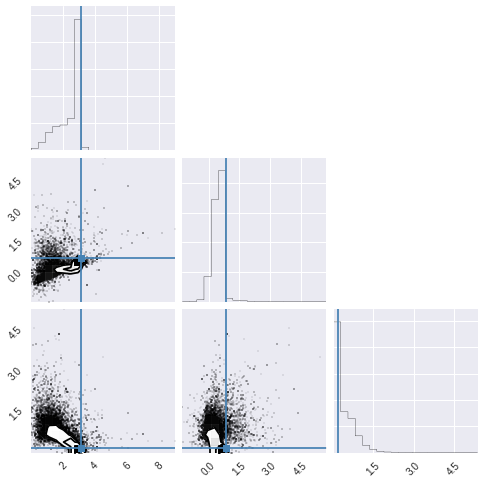

In [16]:
chain = np.loadtxt('is_chain_1000w_100s.gz')
shortChain = np.c_[chain[:,0], chain[:,1], chain[:,4]]
from corner import corner
corner(shortChain, truths = [logL0_true, a_true, sigma_l_true]);